In [7]:
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights
import torchvision.transforms.v2 as v2
from torch import nn
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import time
import torch
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from collections.abc import Mapping
import mlflow
from pprint import pprint
from torchinfo import summary
from torch.utils.data import DataLoader

## Add the path to the utils folder
sys.path.append(str(Path('../src/python').resolve()))
from utils.transform_utils import ShuffleNet_V2_X0_5_FaceTransforms
from utils.constant_utils import celeba_columns
from utils.metric_utils import evaluate_performance
from datasets.CelebA import CelebA


In [ ]:
mlflow.set_tracking_uri('http://localhost:8080')
mlflow.set_experiment('logger_demo')

In [8]:
def create_zero_metrics():
    zero_metrics = {
        'averaged_example_based_accuracy': 0.0,
        'f1_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),  # Assuming the array has 40 elements
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        },
        'hamming_loss': 0.0,
        'precision_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        },
        'recall_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        }
    }
    return zero_metrics

In [16]:
def traverse_dict(dict):
    for key, value in dict.items():
        if isinstance(value, Mapping):
            print(key)
            traverse_dict(value)
        else:
            print(f'{key}: {value}')

In [15]:
metrics = create_zero_metrics()
traverse_dict(metrics)

averaged_example_based_accuracy
averaged_example_based_accuracy: 0.0
f1_score
macro_averaged
macro_averaged: 0.0
micro_averaged
micro_averaged: 0.0
per_label
per_label: [          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0]
sample_average
sample_average: 0.0
weighted_averaged
weighted_averaged: 0.0
hamming_loss
hamming_loss: 0.0
precision_score
macro_averaged
macro_averaged: 0.0
micro_averaged
micro_averaged: 0.0
per_label
per_label: [          0           0           0           0           0           0           0           0           0           0           0  

In [2]:
## Define model and detector
detector = YOLO("../src/python/static/yolov11n-face.pt")
model = shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=1024, out_features=40, bias=True)

torch.Size([3, 224, 224])

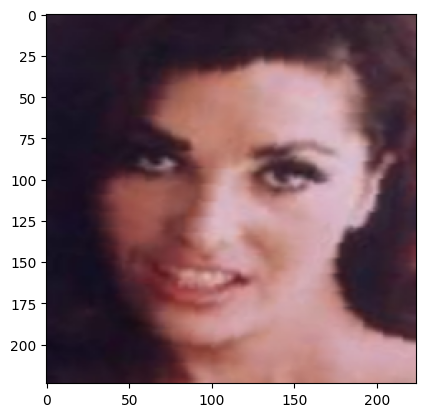

In [3]:
image = Image.open('./downloaded_ds/000011.jpg')
image = ShuffleNet_V2_X0_5_FaceTransforms(detector, pad=15)(image)
plt.imshow(v2.ToPILImage()(image))
image.shape

In [4]:
face = detector.predict(image.unsqueeze(0))
face[0].boxes.conf.numel()


1

In [5]:
epochs = 2
batch_size = 64
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    'epochs': epochs,
    'learning_rate': 1e-3,
    'batch_size': batch_size,
    'optimizer': optimizer.__class__.__name__,
    'loss': criterion.__class__.__name__
}

In [6]:
celeba = CelebA('../data/celeba', transform=ShuffleNet_V2_X0_5_FaceTransforms(detector, pad=15))

/Users/peterbrezovcsik/Documents/PythonProjects/Face_Recognition/notebooks


In [ ]:
print(celeba.attr.shape)
print(celeba.files[0])


In [ ]:
t, _, demo = torch.utils.data.random_split(celeba, [0.7, 0.298, 0.002], torch.Generator().manual_seed(0))
train, val, test = torch.utils.data.random_split(demo, [0.7, 0.2, 0.1], torch.Generator().manual_seed(0))
len(train), len(val), len(test)

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [ ]:

"""
num_of_pos_labels = torch.sum(dataset.labels, dim = 0)
num_of_neg_labels = num_of_labels - num_of_pos_labels

pos_weights = num_of_neg_labels / num_of_pos_labels

obj_pos_weights = pos_weights.index_select(dim=0, index=objective_label_idx)
subj_pos_weights = pos_weights.index_select(dim=0, index=subjective_label_idx)
"""
num_of_labels = len(celeba.attr)
num_of_pos_labels = torch.sum(celeba.attr, dim = 0)
num_of_neg_labels = num_of_labels - num_of_pos_labels
pos_weights = num_of_neg_labels / num_of_pos_labels
pos_weights

In [ ]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
columns = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair',
          'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby','Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
          'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose',
          'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
          'Wearing_Necklace', 'Wearing_Necktie', 'Young']

#### CalculateMetric api class
*    calculates all of the metrics and returns the result as json
*    does not handle mlflow logging

#### MLFlowLogger api class
* when invoked gets the metrics from the CM class api as json
* processes the json and then logs the metrics to the mlflow server

In [ ]:
def create_zero_metrics():
    zero_metrics = {
        'averaged_example_based_accuracy': 0.0,
        'f1_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),  # Assuming the array has 40 elements
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        },
        'hamming_loss': 0.0,
        'precision_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        },
        'recall_score': {
            'macro_averaged': 0.0,
            'micro_averaged': 0.0,
            'per_label': np.zeros(40, dtype=float),
            'sample_average': 0.0,
            'weighted_averaged': 0.0
        }
    }
    return zero_metrics

In [ ]:
class MetricsLogger():
    def __init__(self, columns):
        self.df_f1 = pd.DataFrame(columns=columns)
        self.df_rec = pd.DataFrame(columns=columns)
        self.df_prec = pd.DataFrame(columns=columns)
        
    
    def log_metrics(self, stage, metrics, step):
        
        mlflow.log_metric(f"Loss_{stage}", f"{metrics['loss']:2f}", step=step)
        mlflow.log_metric(f"Hamming_loss_{stage}", f"{metrics['hamming_loss']:2f}", step=step)
        mlflow.log_metric(f'Subset_Accuracy_{stage}', metrics['averaged_example_based_accuracy'], step=step)

        mlflow.log_metric(f'F1_Score_Micro_{stage}', metrics['f1_score']['micro_averaged'], step=step)
        mlflow.log_metric(f'F1_Score_Macro_{stage}', metrics['f1_score']['micro_averaged'], step=step)
        mlflow.log_metric(f'F1_Score_Sample_{stage}', metrics['f1_score']['sample_average'], step=step)
        mlflow.log_metric(f'F1_Score_Weighted_{stage}', metrics['f1_score']['weighted_averaged'], step=step)

        mlflow.log_metric(f'Recall_Micro_{stage}', metrics['recall_score']['micro_averaged'], step=step)
        mlflow.log_metric(f'Recall_Macro_{stage}', metrics['recall_score']['macro_averaged'], step=step)
        mlflow.log_metric(f'Recall_Sample_{stage}', metrics['recall_score']['sample_average'], step=step)
        mlflow.log_metric(f'Recall_Weighted_{stage}', metrics['recall_score']['weighted_averaged'], step=step)

        mlflow.log_metric(f'Precision_Micro_{stage}', metrics['precision_score']['micro_averaged'], step=step)
        mlflow.log_metric(f'Precision_Macro_{stage}', metrics['precision_score']['macro_averaged'], step=step)
        mlflow.log_metric(f'Precision_Sample_{stage}', metrics['precision_score']['sample_average'], step=step)
        mlflow.log_metric(f'Precision_Weighted_{stage}', metrics['precision_score']['weighted_averaged'], step=step)

        """
        self.df_f1.loc[step] = metrics['f1_score']['per_label']
        self.df_rec.loc[step] = metrics['recall_score']['per_label']
        self.df_prec.loc[step] = metrics['precision_score']['per_label']

        print(self.df_f1.loc[step])
        """
        
    
    def save_artifact(self, path):
        mlflow.log_table(self.df_f1, 'f1_score_per_label.json')
        mlflow.log_table(self.df_rec, 'recall_per_label.json')
        mlflow.log_table(self.df_prec, 'precision_per_label.json')

In [ ]:
def add_dicts(dict1, dict2):
    """Recursively adds two dictionaries with the same structure."""
    if not dict1 or not dict2:
        return dict1 or dict2  # Return whichever is not empty

    result = {}
    for key in dict1:
        if isinstance(dict1[key], Mapping):  # If it's a nested dictionary, recurse
            result[key] = add_dicts(dict1[key], dict2[key])
        elif isinstance(dict1[key], np.ndarray):  # Element-wise sum for NumPy arrays
            result[key] = dict1[key] + dict2[key]
        else:  # Normal scalar sum
            result[key] = dict1[key] + dict2[key]

    return result



def divide_dict(d, divisor):
    if divisor == 0:
        raise ValueError("Cannot divide by zero")
    
    if isinstance(d, dict):
        return {k: divide_dict(v, divisor) for k, v in d.items()}
    elif isinstance(d, np.ndarray):
        return d / divisor
    elif isinstance(d, (int, float)):
        return d / divisor
    else:
        return d



def print_metrics(epoch, loss_sum, metrics_sum, avg_metrics, avg_loss):
    print(f'Epoch {epoch + 1} - Summed Loss: {loss_sum}')
    print(f'Epoch {epoch + 1} - Average Loss: {avg_loss}')

    print(f'Summed metrics in epoch {epoch + 1}:')
    pprint(metrics_sum)

    print(f'Avareged metrics in epoch {epoch + 1}:')
    pprint(avg_metrics)

In [ ]:
from mlflow.types import Schema, TensorSpec
from mlflow.models.signature import ModelSignature

input_schema = Schema([TensorSpec(np.dtype(np.float32), (1, 3, 224, 224))])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (1, 40))])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [ ]:
with mlflow.start_run(run_name='TrainDemo') as run:
        mlflow.log_params(params)
        mlflow.set_tag('Training info', 'ShuffleNetV2_X0_5')
        mlflow.pytorch.log_model(model, "model", signature=signature)
        with open("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")

In [ ]:
logged_model = f"runs:/{run.info.run_id}/model"
loaded_model = mlflow.pytorch.load_model(logged_model)
loaded_model(torch.rand(1, 3, 224, 224)).shape

In [ ]:
loaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }

In [ ]:
def train(model, loader, criterion, optimizer, epochs, logger):
    model.train()

    with mlflow.start_run(run_name='TrainDemo'):
        mlflow.log_params(params)
        mlflow.set_tag('Training info', 'ShuffleNetV2_X0_5')
        mlflow.pytorch.log_model(model, "model", signature=signature)
        with open("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")
        mlflow.pytorch.log_model(model, "model", signature=signature)
        
        for epoch in range(epochs):
            loss_sum = 0.0
            metrics_sum = create_zero_metrics()

            for batch, (input, target) in enumerate(loader['train']):
                input = input.to(device)
                target = target.to(device)
                optimizer.zero_grad()

                pred = model(input)
                loss = criterion(pred, target)

                loss.backward()
                optimizer.step()
                
                metrics = evaluate_performance(target.detach(), pred.detach(), threshold=0.5)

                loss_sum += loss.item()
                metrics_sum = add_dicts(metrics_sum, metrics)

            ## Calculate the average loss and metrics
            ## Then log them with MLFlow

            avg_loss = loss_sum / len(loader['train'])
            avg_metrics = divide_dict(metrics_sum, len(loader['train']))
            avg_metrics['loss'] = avg_loss

            ## Log the metrics with MLFlow
            logger.log_metrics('TRAIN', avg_metrics, epoch)
            #logger.save_artifact('.')

            print(f'Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss}')


logger = MetricsLogger(columns)
train(model, loaders, criterion, optimizer, epochs, logger)

## Metric logging tactics
#### When logging metrics only log at every epoch
##### - Logger class' sum function sums the output of evaluate functions.
##### - Logger class' log function averages and logs the sum function
#### Label-wise metrics only logged during testing
##### 